<a href="https://colab.research.google.com/github/sankalpachowdhury/Fractal_Analysis/blob/master/Higuchi_Fractal_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#C codes

In [ ]:
#include <stdio.h>

int main()
{
   int i, j, k, m, n, s=0, l, x=0;
   printf("Enter sample size:");
   scanf("%d",&n);
   printf("Enter largest time delay parameter:");
   scanf("%d",&k);
   int a[n];
   for(i=2;i<=k;i++)
   {
       for(m=0;m<i;m++)
       {
            for(j=m;j<n;j=j+i)
                s=s+a[j+i]-a[j];
            l=(s*(n-1))/(j*i);
            s=0;
            x=x+l;
       }
       printf("The average is %d for k= %d",x/i,i);
       x=0;
   }
}

In [ ]:
#include <stdio.h>

int main()
{
      int n, k, i=0, b=0, s=0, l=0, m;
    printf("Enter sample size:");
    scanf("%d",&n);
    printf("\nEnter the time delay parameter:");
    scanf("%d",&b);
    int a[n];
    while(i<n)
        {
            scanf("%d",&a[i]);
            i++;
        }
    for(k=2;k<=b;k++)
    {
        for(m=0;m<k;m++)
        {
            for(i=m;i<n;i=i+k)
                s=s+a[i+k]-a[i];
            l=l+((s*(n-1))/((i+k)*k));
            s=0;
        }
        printf("\nAvg length %d for %d",l/k,k);
        l=0;
    }

}

In [ ]:
#!git clone https://github.com/inuritdino/HiguchiFractalDimension.git

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [1]:
import os
import ctypes
import numpy as np
from numpy.ctypeslib import ndpointer

def curve_length(X,opt=False,num_k=50,k_max=None):
    """
    Calculate curve length <Lk> for Higuchi Fractal Dimension (HFD)
    
    Input:
    
    X - input (time) series (must be 1D, to be converted into a NumPy array)
    opt (=True) - optimized? (if libhfd.so was compiled uses the faster code).
    num_k - number of k values to generate.
    k_max - the maximum k (the k array is generated uniformly in log space 
            from 2 to k_max)
    Output:
    k - interval "times", window sizes
    Lk - curve length
    """
    ### Make sure X is a NumPy array with the correct dimension
    X = np.array(X)
    if X.ndim != 1:
        raise ValueError("Input array must be 1D (time series).")
    N = X.size

    ### Get interval "time"
    k_arr = interval_t(N,num_val=num_k,kmax=k_max)

    ### The average length
    Lk = np.empty(k_arr.size,dtype=np.float)

    ### C library
    '''
    if opt:
        X = np.require(X, float, ('C', 'A'))
        k_arr = np.require(k_arr, ctypes.c_size_t, ('C', 'A'))
        Lk = np.require(Lk, float, ('C', 'A'))
        ## Load library here
        libhfd = init_lib()
        ## Run the C code here
        libhfd.curve_length(k_arr,k_arr.size,X,N,Lk)
    '''
    #else:
        ### Native Python run
    for i in range(k_arr.size):# over array of k's
            Lmk = 0.0
            for j in range(k_arr[i]):# over m's
                ## Construct X_k^m, i.e. X_(k_arr[i])^j, as X[j::k_arr[i]]
                ## Calculate L_m(k)
                Lmk += (
                    np.sum(
                        np.abs(
                            np.diff( X[j::k_arr[i]] )
                        )
                    )
                    * (N - 1) /
                    (
                        ( (N-j-1)//k_arr[i] )
                        *
                        k_arr[i]
                    )
                ) / k_arr[i]

            ### Calculate the average Lmk
            Lk[i] = Lmk / k_arr[i]

    return (k_arr, Lk);

def lin_fit_hfd(k,L,log=True):
    """
    Calculate Higuchi Fractal Dimension (HFD) by fitting a line to already computed
    interval times k and curve lengths L
    Input:
    k - interval "times", window sizes
    L - curve length
    log (=True) - k and L values will be transformed to np.log2(k) and np.log2(L),
                  respectively
    Output:
    HFD
    """
    if log:
        return (-np.polyfit(np.log2(k),np.log2(L),deg=1)[0]);
    else:
        return (-np.polyfit(k,L,deg=1)[0]);

def hfd(X,**kwargs):
    """
    Calculate Higuchi Fractal Dimension (HFD) for 1D data/series
    Input:
    X - input (time) series (must be 1D, to be converted into a NumPy array)
    Output:
    
    HFD
    """
    k, L = curve_length(X,**kwargs)
    return lin_fit_hfd(k, L);

# Generating th interval
def interval_t(size,num_val=50,kmax=None):
    list_space = []
    ### Generate sequence of interval times, k
    if kmax is None:
        k_stop = size//2
    else:
        k_stop = kmax
    if k_stop > size//2:   ## prohibit going larger than N/2
        k_stop = size//2
        print("Warning: k cannot be longer than N/2")
    for i in range(2, k_stop):
      list_space.append(i)    
    #k = np.logspace(start=np.log2(2),stop=np.log2(k_stop),base=2,num=num_val,dtype=np.int)
    return np.unique(list_space);

def init_lib():
    libdir = os.path.dirname(__file__)
    libfile = os.path.join(libdir, "libhfd.so")
    lib = ctypes.CDLL(libfile)

    rwptr = ndpointer(float, flags=('C','A','W'))
    rwptr_sizet = ndpointer(ctypes.c_size_t, flags=('C','A','W'))

    lib.curve_length.restype = ctypes.c_int
    lib.curve_length.argtypes = [rwptr_sizet, ctypes.c_size_t, rwptr, ctypes.c_size_t, rwptr]

    return lib;

In [28]:
x = np.random.randn(1000)
y = np.empty(990)
for i in range(x.size-10):
	y[i] = np.sum(x[:(i+10)])
 
for i in x:
  print(i)



0.019733470962794895
0.7542514774220994
0.09645375449396365
0.1319981047403004
-1.698611091188219
-0.6830530424117208
0.6752892740046557
1.5867503270981758
0.3946334707422419
-0.7834667705007754
-0.2510475648986225
0.652176692771868
-0.5450897945139386
0.5678050905547972
0.5823822106906947
0.5025645291610844
-0.21786868718459845
-0.7511078773574711
-0.6329973012137275
-0.10480684483101665
0.638154097299078
-1.1663256078630573
-0.4022786214097342
1.1474402480834731
0.36711783593725705
0.7841043041439169
1.7814898550365084
-0.037940819450956335
1.294861584771821
-0.5533978412133708
-0.8596464607122272
0.18219262621310553
0.19325703221043578
0.5834912900474706
-0.8993732531928526
-1.221866083571623
1.3899460739876994
-0.7293988813049885
-1.9148054844880429
-0.85313360467797
-0.010682445912623293
-1.0983388737022082
1.2634646511566476
0.0941926769582492
0.9013410784209926
-0.6559870734001738
0.43842466308564404
1.9970345215328547
-0.43732948133436017
0.6283584454906774
0.9133480465724111
-

In [29]:
for j in y:
  print(i)

1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671550162
1.0614248671

In [3]:
# Validation of the algorithm
x = np.random.randn(1000)
y = np.empty(990)
for i in range(x.size-10):
	y[i] = np.sum(x[:(i+10)])
	
## Note x is a Guassian noise, y is the original Brownian data used in Higuchi, Physica D, 1988.

print(hfd(x)) # ~ 2.00
print(hfd(y)) # ~ 1.50
#print(a, b)

2.0010903679144025
1.627298872035694


In [4]:
k, l = curve_length((x))
print(k, l)

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 24

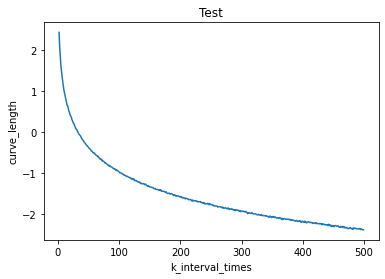

In [5]:
import math
#x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in l:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Test") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(k,y) 
plt.show()

Raw fit results:
poly([-0.23988073 -0.00508538])
[array([71.47222273]), 2, array([1.36649965, 0.36425087]), 1.1057821325266559e-13]
Fit: A = -0.005[P] + -0.240 (rms residual = 0.3788)


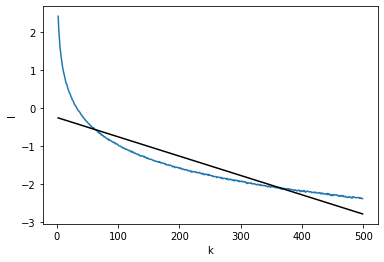

In [6]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
conc = k
A = y

cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

pylab.plot(conc, A)
pylab.plot(conc, pfit(conc), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

In [ ]:
# Linear Regression

import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
x = np.array([5, 15, 25, 35, 45, 55]).reshape((-1, 1))
y = np.array([5, 20, 14, 32, 22, 38])

In [ ]:
model = LinearRegression()
model.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
model = LinearRegression().fit(x, y)

In [ ]:
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.7158756137479542


In [ ]:
print('intercept:', model.intercept_)

intercept: 5.633333333333329


In [ ]:
print('slope:', model.coef_)

slope: [0.54]


In [ ]:
new_model = LinearRegression().fit(x, y.reshape((-1, 1)))
print('intercept:', new_model.intercept_)
print('slope:', new_model.coef_)

intercept: [5.63333333]
slope: [[0.54]]


In [ ]:
y_pred = model.predict(x)
print('predicted response:', y_pred, sep='\n')

predicted response:
[ 8.33333333 13.73333333 19.13333333 24.53333333 29.93333333 35.33333333]


In [ ]:
y_pred = model.intercept_ + model.coef_ * x
print('predicted response:', y_pred, sep='\n')

predicted response:
[[ 8.33333333]
 [13.73333333]
 [19.13333333]
 [24.53333333]
 [29.93333333]
 [35.33333333]]


In [ ]:
x_new = np.arange(5).reshape((-1, 1))
print(x_new)

[[0]
 [1]
 [2]
 [3]
 [4]]


Estimated coefficients:
b_0 = 182.8376262481708  nb_1 = -0.06738456743257776


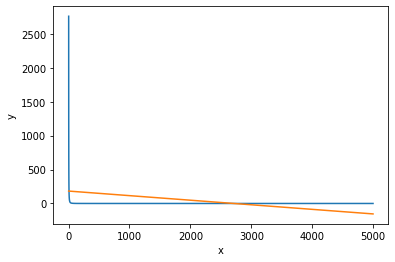

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
  
def estimate_coef(x, y): 
    # number of observations/points 
    n = np.size(x) 
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return(b_0, b_1) 
  
def plot_regression_line(x, y, b): 
    # plotting the actual points as scatter plot 
    #plt.scatter(x, y, color = "m", marker = "o", s = 30) 
    plt.plot(x, y)
  
    # predicted response vector 
    y_pred = b[0] + b[1]*x 
  
    # plotting the regression line 
    #plt.plot(x, y_pred, color = "g") 
    plt.plot(x, y_pred)
  
    # putting labels 
    plt.xlabel('x') 
    plt.ylabel('y') 
  
    # function to show plot 
    plt.show() 
  
def main(): 
    # observations 
    x = k  # np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) 
    y = l  # np.array([1, 3, 2, 5, 7, 8, 8, 9, 10, 12]) 
  
    # estimating coefficients 
    b = estimate_coef(x, y) 
    print("Estimated coefficients:\nb_0 = {}  nb_1 = {}".format(b[0], b[1])) 
  
    # plotting regression line 
    plot_regression_line(x, y, b) 
  
if __name__ == "__main__": 
    main()

#Data Preprocessing

In [7]:
data = pd.read_csv('/content/AVG_DATA.csv')
data.head()

,DATE,SNO.,MAHARASHTRA,ANDHRA PRADESH,TAMIL NADU,KARNATAKA,UTTAR PRADESH,DELHI,WEST BENGAL
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01/04/2020,1.0,33.0,67.0,110.0,9.0,13.0,32.0,37.0
2,02/04/2020,2.0,62.0,40.0,96.0,9.0,23.0,89.0,18.0
3,03/04/2020,3.0,89.0,42.0,89.0,10.0,35.0,77.0,16.0
4,04/04/2020,4.0,107.0,38.0,77.0,11.0,38.0,75.0,9.0


In [8]:
maha = data.MAHARASHTRA
print(maha[1:154])

andhra = data['ANDHRA PRADESH']
print(andhra[1:154])

tamil = data['TAMIL NADU']
print(tamil[1:154])

karna = data.KARNATAKA
print(karna[1:154])

up = data['UTTAR PRADESH']
print(up[1:154])

delhi = data['DELHI']
print(delhi[1:154])

wb = data['WEST BENGAL']
print(wb[1:154])

1         33.0
2         62.0
3         89.0
4        107.0
5        119.0
        ...   
149    14177.0
150    15373.0
151    14766.0
152    14849.0
153    11852.0
Name: MAHARASHTRA, Length: 153, dtype: float64
1         67.0
2         40.0
3         42.0
4         38.0
5         33.0
        ...   
149    10490.0
150    10626.0
151    10460.0
152    10385.0
153    10004.0
Name: ANDHRA PRADESH, Length: 153, dtype: float64
1       110.0
2        96.0
3        89.0
4        77.0
5        76.0
        ...  
149    6048.0
150    6156.0
151    6156.0
152    6268.0
153    5956.0
Name: TAMIL NADU, Length: 153, dtype: float64
1         9.0
2         9.0
3        10.0
4        11.0
5        10.0
        ...  
149    8682.0
150    8820.0
151    8403.0
152    7890.0
153    6495.0
Name: KARNATAKA, Length: 153, dtype: float64
1        13.0
2        23.0
3        35.0
4        38.0
5        41.0
        ...  
149    5415.0
150    5649.0
151    5477.0
152    5530.0
153    4782.0
Name: UTTAR PRADESH,

In [9]:
import pandas
print(pandas.__version__)

1.0.5


In [10]:
# convert dataframe to np.array
import numpy
maha_np_array = data['MAHARASHTRA'].to_numpy()
#maha_np_array = list(numpy.concatenate().flat)) 
print(maha_np_array[1:154])

andhra_np_array = andhra.to_numpy()
print(andhra_np_array[1:154])

tamil_np_array = tamil.to_numpy()
print(tamil_np_array[1:154])

karna_np_array = karna.to_numpy()
print(karna_np_array[1:154])

up_np_array = up.to_numpy()
print(up_np_array[1:154])

delhi_np_array = delhi.to_numpy()
print(delhi_np_array[1:154])

wb_np_array = wb.to_numpy()
print(wb_np_array[1:154])

[   33.    62.    89.   107.   119.   130.   146.   165.   179.   193.
   240.   263.   268.   288.   268.   263.   304.   350.   403.   466.
   556.   523.   592.   570.   588.   578.   620.   574.   688.   741.
   731.   925.  1005.  1050.  1136.  1218.  1137.  1329.  1329.  1291.
  1372.  1459.  1386.  1461.  1725.  1827.  1922.  2039.  2187.  2306.
  2426.  2619.  2674.  2623.  2473.  2471.  2399.  2500.  2579.  2613.
  2551.  2526.  2525.  2515.  2591.  2735.  2734.  2599.  2762.  2936.
  3033.  3208.  3434.  3341.  3159.  3122.  3187.  3275.  3492.  3726.
  3809.  3701.  3714.  3907.  4138.  4667.  5123.  5397.  5404.  5507.
  5499.  5673.  6036.  6372.  6338.  6099.  6147.  6107.  6368.  6923.
  7461.  7080.  7053.  7076.  7176.  7272.  8003.  8558.  8611.  8550.
  9004.  9313.  9332.  9535.  9754.  9223.  8788.  8707.  9086.  9264.
  9599.  9958.  9909.  9232.  9229.  9612.  9807. 10578. 11475. 11250.
 11164. 11610. 11408. 11480. 12048. 12053. 11209. 11070. 11182. 11707.
 12317

#MAHARASHTRA



In [11]:
# inputs to Higuchi Algorithm

# k_value = int(input("Enter the bound og 'k' "))
data_list = maha_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 4
Max. k value: 14
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75] [13612.54333333  7888.57481481  5054.38344595  3503.97108966
  2598.36493827  2107.39675135  1800.515625    1623.8484225
  1471.8232381   1333.35425456  1203.46061308  1101.10845368
  1017.75066408   947.52771687   885.33794488   833.17687767
   789.75614834   750.01385042   712.41811905   679.25197834
   650.8401703    623.87003096   599.52806713   577.0639872
   555.85464269   535.39090586   514.9976312    496.51785641
   479.19463704   464.05214103   450.07177734   437.73577835
   425.39683832   412.37319339   400.98812586   389.29925835
   380.22645429   371.67855156   363.64614583   356.31191267
   348.43317856   341.54929755   334.72927623   327.96554184
   320.99047971   313.77532917   307.13505498 

In [12]:
hfd(data_list)

1.07049676773535

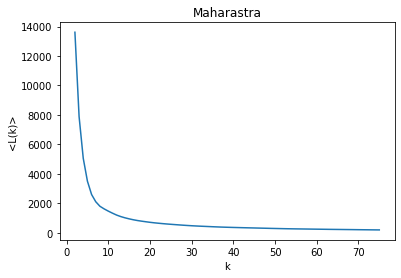

In [16]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
#for i in curve_length_list:
#  log_y.append(math.log10(i))
#y = log_y
y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Maharastra") 
plt.xlabel("k") 
plt.ylabel("<L(k)>") 
plt.plot(x,y) 
plt.show()

Raw fit results:
poly([2651.36568087  -44.9245958 ])
[array([1.90591622e+08]), 2, array([1.36910029, 0.35435068]), 1.6431300764452317e-14]
Fit: A = -44.925[P] + 2651.366 (rms residual = 1604.8559)


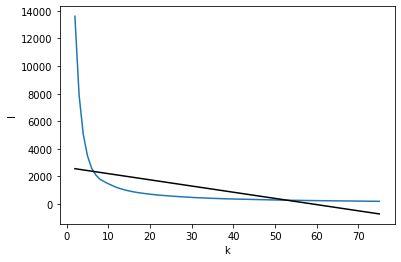

In [17]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
conc = k_interval_times
A = curve_length_list

cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

pylab.plot(conc, A)
pylab.plot(conc, pfit(conc), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

Estimated coefficients:
b_0 = 2651.3656808736223  nb_1 = -44.92459579726967


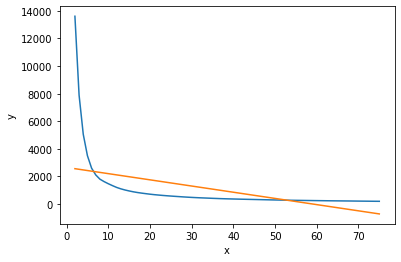

In [15]:
import numpy as np 
import matplotlib.pyplot as plt 
  
def estimate_coef(x, y): 
    # number of observations/points 
    n = np.size(x) 
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return(b_0, b_1) 
  
def plot_regression_line(x, y, b): 
    # plotting the actual points as scatter plot 
    #plt.scatter(x, y, color = "m", marker = "o", s = 30) 
    plt.plot(x, y)
  
    # predicted response vector 
    y_pred = b[0] + b[1]*x 
  
    # plotting the regression line 
    #plt.plot(x, y_pred, color = "g") 
    plt.plot(x, y_pred)
  
    # putting labels 
    plt.xlabel('x') 
    plt.ylabel('y') 
  
    # function to show plot 
    plt.show() 
  
def main(): 
    # observations 
    x = k_interval_times #k  # np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) 
    y = curve_length_list #l  # np.array([1, 3, 2, 5, 7, 8, 8, 9, 10, 12]) 
  
    # estimating coefficients 
    b = estimate_coef(x, y) 
    print("Estimated coefficients:\nb_0 = {}  nb_1 = {}".format(b[0], b[1])) 
  
    # plotting regression line 
    plot_regression_line(x, y, b) 
  
if __name__ == "__main__": 
    main()

#ANDHRA PRADESH

In [ ]:
# k_value = int(input("Enter the bound og 'k' "))
data_list = andhra_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 4
Max. k value: 14
[ 2  3  4  6  8 10 14 18 24 32 43 57 75] [16382.17666667  8478.78518519  5338.59966216  2503.89975309
  1736.4140625   1390.20140952   874.99277616   670.48442093
   488.46126543   376.9601237    293.87584322   191.16774392
   146.30713837]


In [ ]:
hfd(data_list)

1.2122976121629008

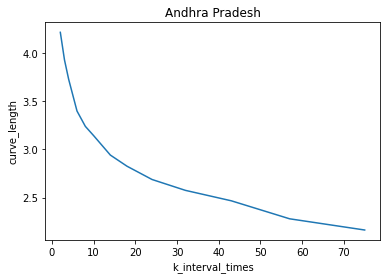

In [ ]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Andhra Pradesh") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(x,y) 
plt.show()

Raw fit results:
poly([5435.66842944 -107.40325518])
[array([1.92442346e+08]), 2, array([1.31074049, 0.53099847]), 2.886579864025407e-15]
Fit: A = -107.403[P] + 5435.668 (rms residual = 3847.5001)


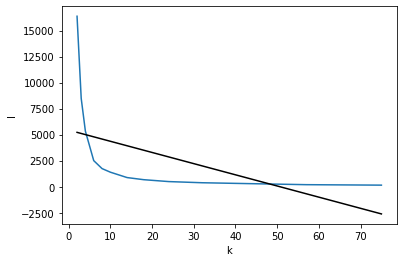

In [ ]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
conc = k_interval_times
A = curve_length_list

cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

pylab.plot(conc, A)
pylab.plot(conc, pfit(conc), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

#TAMIL NADU

In [ ]:
# k_value = int(input("Enter the bound og 'k' "))
data_list = tamil_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 4
Max. k value: 14
[ 2  3  4  6  8 10 14 18 24 32 43 57 75] [7480.13333333 4309.59407407 2948.45945946 1731.50166667 1175.64236111
  862.11794286  549.31849692  419.08208407  319.32351466  241.38952637
  192.24427199  151.15666359  116.6682643 ]


In [ ]:
hfd(data_list)

1.113765449516064

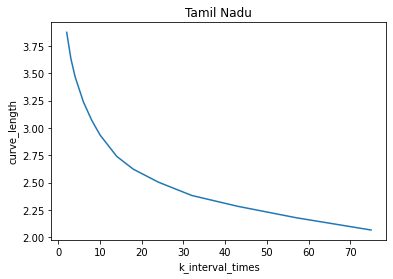

In [ ]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Tamil Nadu") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(x,y) 
plt.show()

Raw fit results:
poly([2807.62269888  -54.06237644])
[array([38228930.81228372]), 2, array([1.31074049, 0.53099847]), 2.886579864025407e-15]
Fit: A = -54.062[P] + 2807.623 (rms residual = 1714.8431)


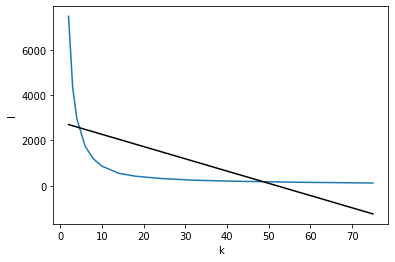

In [ ]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
conc = k_interval_times
A = curve_length_list

cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

pylab.plot(conc, A)
pylab.plot(conc, pfit(conc), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

#KARNATAKA

In [ ]:
# k_value = int(input("Enter the bound og 'k' "))
data_list = karna_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 4
Max. k value: 14
[ 2  3  4  6  8 10 14 18 24 32 43 57 75] [13904.28666667  7063.83407407  4092.52702703  2078.86623457
  1311.95225694  1005.67615238   633.13576288   500.29004997
   365.24457948   274.22513835   209.02557008   152.79244896
   113.81147496]


In [ ]:
hfd(data_list)

1.23034742019409

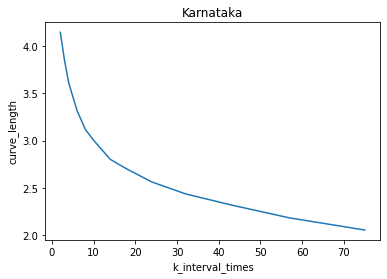

In [ ]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Karnataka") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(x,y) 
plt.show()

Raw fit results:
poly([4459.24338175  -88.73140718])
[array([1.40786955e+08]), 2, array([1.31074049, 0.53099847]), 2.886579864025407e-15]
Fit: A = -88.731[P] + 4459.243 (rms residual = 3290.8609)


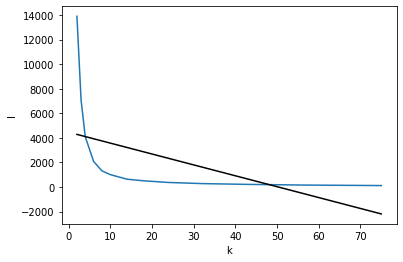

In [ ]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
conc = k_interval_times
A = curve_length_list

cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

pylab.plot(conc, A)
pylab.plot(conc, pfit(conc), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

#UTTAR PRADESH

In [ ]:
# k_value = int(input("Enter the bound og 'k' "))
data_list = up_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 4
Max. k value: 14
[ 2  3  4  6  8 10 14 18 24 32 43 57 75] [7276.78333333 3243.11703704 2192.49493243 1144.23512346  801.60677083
  619.39710476  409.40907029  311.50431119  236.86886574  181.04774984
  132.89047086   91.3507746    69.70364207]


In [ ]:
hfd(data_list)

1.1797410459829762

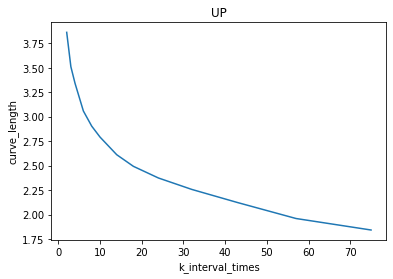

In [ ]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("UP") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(x,y) 
plt.show()

Raw fit results:
poly([2324.55079541  -45.63767282])
[array([36327575.87472971]), 2, array([1.31074049, 0.53099847]), 2.886579864025407e-15]
Fit: A = -45.638[P] + 2324.551 (rms residual = 1671.6545)


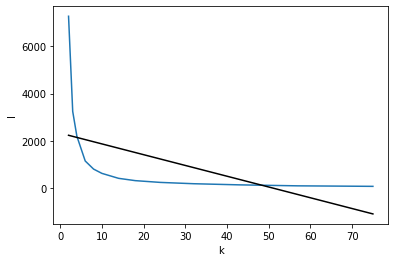

In [ ]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
conc = k_interval_times
A = curve_length_list

cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

pylab.plot(conc, A)
pylab.plot(conc, pfit(conc), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

# DELHI

In [ ]:
# k_value = int(input("Enter the bound og 'k' "))
data_list = delhi_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 4
Max. k value: 14
[ 2  3  4  6  8 10 14 18 24 32 43 57 75] [9873.94       4670.34074074 2923.4222973  1412.29345679  967.42100694
  738.72361905  445.43275024  331.86145405  231.66219136  157.55635579
  108.49359176   63.36144455   33.64338726]


In [ ]:
hfd(data_list)

1.4440076188542394

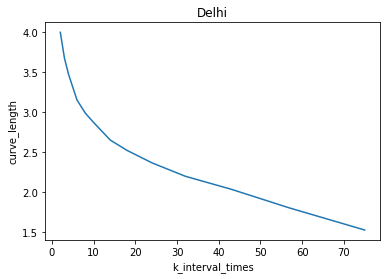

In [ ]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("Delhi") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(x,y) 
plt.show()

Raw fit results:
poly([3117.69113992  -62.74267744])
[array([69716007.69532676]), 2, array([1.31074049, 0.53099847]), 2.886579864025407e-15]
Fit: A = -62.743[P] + 3117.691 (rms residual = 2315.7655)


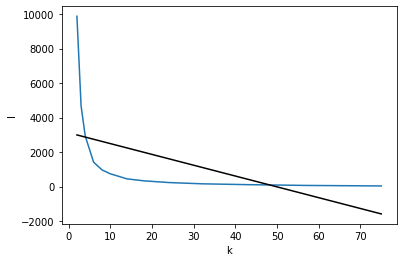

In [ ]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
conc = k_interval_times
A = curve_length_list

cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

pylab.plot(conc, A)
pylab.plot(conc, pfit(conc), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

#WEST BENGAL

In [ ]:
# k_value = int(input("Enter the bound og 'k' "))
data_list = wb_np_array[1:154]
#data_list = data_list.reshape(-1)
print(data_list.shape)
num_k =  int(input("Number of k values to generate: "))  #number of k values to generate.
k_max =  int(input("Max. k value: "))  #the maximum k the k array is generated uniformly in log space from 2 to k_max

k_interval_times, curve_length_list = curve_length(data_list, num_k, k_max)
print(k_interval_times, curve_length_list)

(153,)
Number of k values to generate: 4
Max. k value: 14
[ 2  3  4  6  8 10 14 18 24 32 43 57 75] [3177.24666667 1718.50074074 1172.41891892  685.10950617  485.81684028
  368.98144762  251.3483965   197.57272683  150.60688657  115.52960205
   88.98864251   66.73848364   48.35014163]


In [ ]:
hfd(data_list)

1.0802491601018411

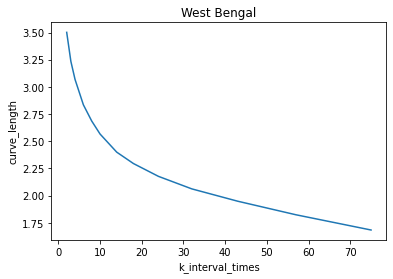

In [ ]:
import math
x = k_interval_times
#x = np.logspace(curve_length[0], curve_length[len(curve_length) - 1], len(curve_length))
log_y = []
for i in curve_length_list:
  log_y.append(math.log10(i))
y = log_y
#y = curve_length_list
#y = np.logspace(k_interval_times[0], k_interval_times[len(k_interval_times) - 1], len(k_interval_times)) 

plt.title("West Bengal") 
plt.xlabel("k_interval_times") 
plt.ylabel("curve_length") 
plt.plot(x,y) 
plt.show()

Raw fit results:
poly([1161.59771964  -22.20797755])
[array([6700810.8000144]), 2, array([1.31074049, 0.53099847]), 2.886579864025407e-15]
Fit: A = -22.208[P] + 1161.598 (rms residual = 717.9464)


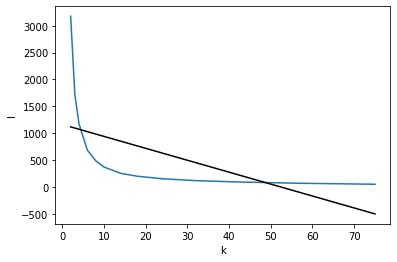

In [ ]:
import numpy as np
import pylab
Polynomial = np.polynomial.Polynomial

# The data: conc = [P] and absorbance, A
conc = k_interval_times
A = curve_length_list

cmin, cmax = min(conc), max(conc)
pfit, stats = Polynomial.fit(conc, A, 1, full=True, window=(cmin, cmax),
                                                    domain=(cmin, cmax))

print('Raw fit results:', pfit, stats, sep='\n')

A0, m = pfit
resid, rank, sing_val, rcond = stats
rms = np.sqrt(resid[0]/len(A))

print('Fit: A = {:.3f}[P] + {:.3f}'.format(m, A0),
      '(rms residual = {:.4f})'.format(rms))

pylab.plot(conc, A)
pylab.plot(conc, pfit(conc), color='k')
pylab.xlabel('k')
pylab.ylabel('l')
pylab.show()

#Analysis